In this final tutorial we will show how to use EKO interfaced with LHAPDF to check different properties of PDFs. 


In [ ]:
!lhapdf install CT14llo
!lhapdf install NNPDF40_nnlo_as_01180

In [1]:
import numpy as np
import pandas as pd
import lhapdf
import pathlib
from matplotlib import pyplot as plt
import eko
from eko.interpolation import lambertgrid
from ekobox.cards import example

## Evolving a PDF

Here we illustrate how to get (and install) directly a LHAPDF set evolved with eko. 

Now, we set the theory inputs: in this example we will evolve our PDF at LO and create a new LHAPDF object with
a size two `mugrid`.

In [2]:
th_card = example.theory()
op_card = example.operator()
# here we replace the grid with a very minimal one, to speed up the example
op_card.xgrid = eko.interpolation.XGrid([1e-3, 1e-2, 1e-1, 5e-1, 1.0])
op_card.mugrid = [[10.0, 5], [100.0, 5]]
# set QCD LO evolution
th_card.order = (1, 0)

We are ready to run eko and install the new PDF set.
Note, that if the evolved PDF already exists, the code will overwrite it.

You can set the variable `path` in `evolve_pdfs` to load a precomputed EKO, while setting `store_path` you can save the produced EKO and reuse it later.
You can also iterate on the given PDF objects (e.g. replicas).

In [7]:
from ekobox.evol_pdf import evolve_pdfs

# choose a PDFs set as a boundary condition
pdf = lhapdf.mkPDF("NNPDF40_nnlo_as_01180")

# set a path to store the eko
path = pathlib.Path("./myeko2.tar")
# and delete it in case it is already present
path.unlink(missing_ok=True)

evolve_pdfs([pdf], th_card, op_card, name="my_first_PDF", store_path=path, install=True)

LHAPDF 6.5.4 loading /Users/manuel/Desktop/ComoSchool/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


Overwriting old PDF installation


install_pdf my_first_PDF


Now, you can access the evolved PDF as all the other PDF sets (note that this requires the Python interface of lhapdf).

In [8]:
evolved_pdf = lhapdf.mkPDF("my_first_PDF", 0)

LHAPDF 6.5.4 loading /Users/manuel/Desktop/ComoSchool/share/LHAPDF/my_first_PDF/my_first_PDF_0000.dat
my_first_PDF PDF set, member #0, version 1


To obtain the value of the gluon PDF at a given scale you can simply do:

In [9]:
pid = 21  # gluon pid
mu2 = 89.10  # mu^2 in Gev^2
x = 0.01  # momentum fraction

# check that the particle is present
print("Is gluon in our PDF?", evolved_pdf.hasFlavor(pid))
# now, let's do a lookup
xg = evolved_pdf.xfxQ2(pid, x, mu2)
print(f"xg(x={x}, mu^2={mu2}) = {xg}")

Is gluon in our PDF? True
xg(x=0.01, mu^2=89.1) = 5.880915013057697


## Benchmark to CT14llo

In this part of the tutorial we do an eko benchmark showing how PDFs evolved with eko can reproduce the values from the original LHAPDF grids.

First, we need to set up the theory and operator runcards to match the settings used to produce the chosen PDF, here we will use `CT14llo`.

We have to use LO evolution and we choose to dump our PDF into grids with 5 values of `mu2` and 60 points.

In [10]:
from eko.quantities.heavy_quarks import QuarkMassRef, HeavyQuarks


# get the PDF object
ct14llo = lhapdf.mkPDF("CT14llo")

# setup the operator card
op_card = example.operator()
op_card.xgrid = eko.interpolation.XGrid(lambertgrid(60))  # x grid
op_card.mugrid = [
    (float(mu), 4 if mu <= 4.75 else 5) for mu in np.geomspace(5.0, 100, 5)
]  # mu, nf grid
op_card.mu0 = 1.295000  # starting point for the evolution

# setup the theory card - this can be mostly inferred from the PDF's .info file

th_card = example.theory()
th_card.order = (1, 0)  # QCD LO
th_card.heavy.masses = HeavyQuarks(
    [
        QuarkMassRef([1.3, np.nan]),
        QuarkMassRef([4.75, np.nan]),
        QuarkMassRef([172.0, np.nan]),
    ]
)  # quark mass
th_card.couplings.alphas = 0.130000  # reference value of alpha_s
th_card.couplings.scale = 91.1876  # the reference scale at which alpha_s is provided
th_card.couplings.num_flavs_ref = (
    5  # the number of flavors active at the alpha_s reference scale
)
th_card.couplings.num_flavs_init = (
    3  # the number of flavors active at the reference scale
)

LHAPDF 6.5.4 loading /Users/manuel/Desktop/ComoSchool/share/LHAPDF/CT14llo/CT14llo_0000.dat
CT14llo PDF set, member #0, version 1; LHAPDF ID = 13205


Next, we run the evolution and save the new PDF. Due to the extended `x` grid and `mu2` grid this might take a minute so please be patient ...

In [11]:
path = pathlib.Path("./myeko_ct14llo.tar")
path.unlink(missing_ok=True)
evolve_pdfs(
    [ct14llo], th_card, op_card, name="my_ct14llo", store_path=path, install=True
)

install_pdf my_ct14llo


Now, we can compare the values given by the original PDF set and the one evolved with eko, both at different `x` and `mu2` scales, for a chosen parton,
here we look at the gluon:

In [12]:
# load evolved pdf
my_ct14llo = lhapdf.mkPDF("my_ct14llo", 0)

# let's check the gluon as an example
pid = 21

# collect data
log = {"x": [], "mu2": [], "ct14llo": [], "my_ct14llo": [], "relative_diff": []}
for mu2 in np.geomspace(25.0, 10000, 5):
    for x in np.geomspace(1e-5, 0.9, 5):
        value = ct14llo.xfxQ2(pid, x, mu2)
        my_value = my_ct14llo.xfxQ2(pid, x, mu2)
        log["x"].append(x)
        log["mu2"].append(mu2)
        log["ct14llo"].append(value)
        log["my_ct14llo"].append(my_value)
        log["relative_diff"].append((value - my_value) * 100 / value)

LHAPDF 6.5.4 loading /Users/manuel/Desktop/ComoSchool/share/LHAPDF/my_ct14llo/my_ct14llo_0000.dat
my_ct14llo PDF set, member #0, version 1


In [13]:
pd.DataFrame(log)

,x,mu2,ct14llo,my_ct14llo,relative_diff
0,0.000010,25.000000,7.635785e+01,7.631803e+01,0.052146
1,0.000173,25.000000,3.194273e+01,3.192650e+01,0.050820
2,0.003000,25.000000,1.081843e+01,1.081271e+01,0.052915
3,0.051962,25.000000,1.958956e+00,1.958160e+00,0.040615
4,0.900000,25.000000,1.922415e-05,1.286529e-05,33.077443
5,0.000010,111.803399,1.333957e+02,1.333606e+02,0.026371
6,0.000173,111.803399,4.777286e+01,4.776030e+01,0.026303
7,0.003000,111.803399,1.341028e+01,1.340691e+01,0.025129
8,0.051962,111.803399,1.978216e+00,1.978127e+00,0.004503
9,0.900000,111.803399,6.644805e-06,3.727413e-06,43.904855


As you can see EKO is able to reproduce the numbers from the original LHAPDF grid mostly below the permille level.

The accuracy is mainly limited by the number of points in the `x` and `mu2` grids that can be finer to achieve higher precision.

You can also notice that at large-x the gluon pdf vanishes so the worst accuracy of our benchmark is not worrying.

## DGLAP effects on PDFs

We can now try to see what is the effect of DGLAP evolution on different PDFs.

Let's take a look at the two coupled distributions, gluon and singlet:

$$ \Sigma = \sum_{i=0}^{n_f} q_i + \bar{q}_i $$


To show this we will plot the NNPDF4.0 NNLO at different $\mu$ scales, taking advantage of the precomputed LHAPDF grids.

LHAPDF 6.5.4 loading /Users/manuel/Desktop/ComoSchool/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


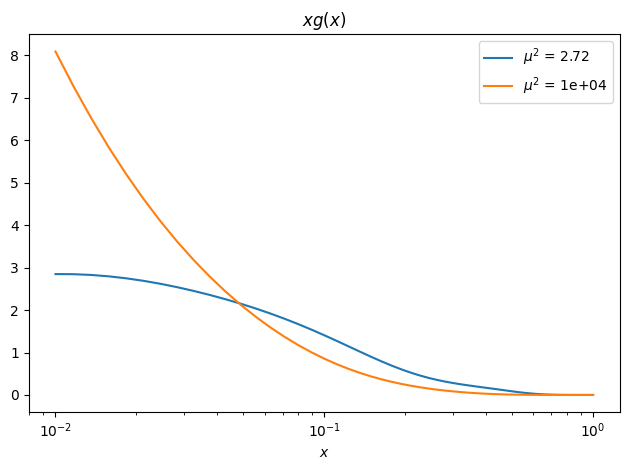

In [14]:
# select the PDF
pdf = lhapdf.mkPDF("NNPDF40_nnlo_as_01180")

# x_grid
x_grid = lambertgrid(60, x_min=1e-2)
mu2_grid = np.array([1.65, 100]) ** 2


# plot gluon
pid = 21
for mu2 in mu2_grid:
    plt.plot(
        x_grid, [pdf.xfxQ2(pid, x, mu2) for x in x_grid], label=f"$\\mu^2$ = {mu2:.3g}"
    )
plt.title("$x g(x)$")
plt.xlabel("$x$")
plt.xscale("log")
plt.legend()
plt.tight_layout()
plt.show()

To plot the singlet PDF we must rotate the flavors to evolution basis. EKO provides the matrix to do it! 

In [15]:
from eko import basis_rotation as br

print(br.flavor_basis_pids)
print(br.evol_basis)
print(br.rotate_flavor_to_evolution)

(22, -6, -5, -4, -3, -2, -1, 21, 1, 2, 3, 4, 5, 6)
('ph', 'S', 'g', 'V', 'V3', 'V8', 'V15', 'V24', 'V35', 'T3', 'T8', 'T15', 'T24', 'T35')
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  1  1  1  1  0  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 -1 -1 -1 -1 -1 -1  0  1  1  1  1  1  1]
 [ 0  0  0  0  0 -1  1  0 -1  1  0  0  0  0]
 [ 0  0  0  0  2 -1 -1  0  1  1 -2  0  0  0]
 [ 0  0  0  3 -1 -1 -1  0  1  1  1 -3  0  0]
 [ 0  0  4 -1 -1 -1 -1  0  1  1  1  1 -4  0]
 [ 0  5 -1 -1 -1 -1 -1  0  1  1  1  1  1 -5]
 [ 0  0  0  0  0  1 -1  0 -1  1  0  0  0  0]
 [ 0  0  0  0 -2  1  1  0  1  1 -2  0  0  0]
 [ 0  0  0 -3  1  1  1  0  1  1  1 -3  0  0]
 [ 0  0 -4  1  1  1  1  0  1  1  1  1 -4  0]
 [ 0 -5  1  1  1  1  1  0  1  1  1  1  1 -5]]


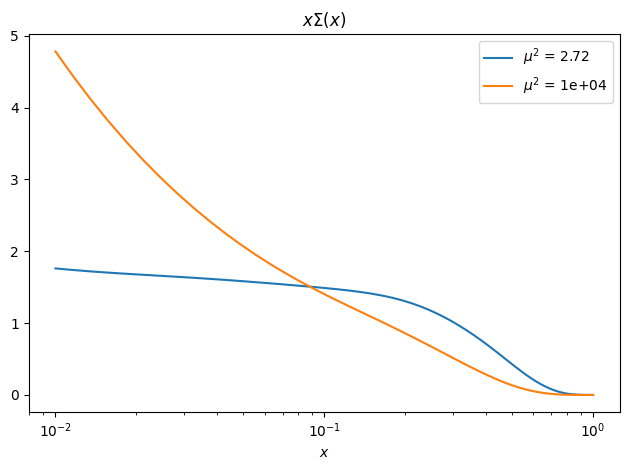

In [16]:
# loop in mu2
for mu2 in mu2_grid:
    pdfs_flavor = []
    # loop on flavors
    for pid in br.flavor_basis_pids:
        if pdf.hasFlavor(pid):
            pdfs_flavor.append([pdf.xfxQ2(pid, x, mu2) for x in x_grid])
        else:
            pdfs_flavor.append(np.zeros_like(x_grid))

    # rotate to evolution
    pdf_evol = br.rotate_flavor_to_evolution @ pdfs_flavor

    # select singlet values
    singlet_vals = pdf_evol[1]

    # plot
    plt.plot(x_grid, singlet_vals, label=f"$\\mu^2$ = {mu2:.3g}")

plt.title("$x \Sigma(x)$")
plt.xlabel("$x$")
plt.xscale("log")
plt.legend()
plt.tight_layout()
plt.show()

We can observe that DGLAP raises Singlet and gluon at small-x, due to the logarithm of type $\log(x)/x $ present in the splitting functions.
On contrary the large-x region appear suppressed at higher values of $\mu$.

**Exercise**: 

By using the rotation matrix provided by EKO, plot the valence distribution, which is defined as:

$$ V = \sum_{i=0}^{n_f} q_i - \bar{q}_i $$


Which are the effects of the DGLAP evolution on this distribution? 

## Sum rules

PDFs are probabilities distribution (more precisely are functional probabilities) and thus obey to some conservation laws: 

* Momentum conservation: 

$$ \sum_{i=1}^{n_f} \int_0^{1}dx\, x q_i(x) + \int_0^{1}dx\, x g(x) = 1 $$

* Quark number conservation: 

$$ \int_0^{1}dx\, u(x) - \bar{u}(x) = 2 \quad\text{and}\quad \int_0^{1}dx\, d(x) - \bar{d}(x) = 1  $$


Using LHAPDF we can check how these sum rules are not violated during DGLAP evolution.


In [68]:
from scipy.integrate import quad

# select the PDF
pdf = lhapdf.mkPDF("my_ct14llo")

# set a  mu scale
mu = 25.0


# define the integrand
def integrand(pid, x):
    return (pdf.xfxQ2(pid, x, mu**2) - pdf.xfxQ2(-pid, x, mu**2)) / x


def integrand2(pid,x):
    return pdf.xfxQ2(pid,x,mu**2)
    
# select up and down pids
pids = {"d": 1, "u": 2}
#print(pids("u"))

for quark, pid in pids.items():
    sum_rule = quad(lambda x: integrand(pid, x), 0, 1, points=(0, 1), epsabs=1e-4)[0]
    print(f"{quark} sum rule evaluated to : {sum_rule}")

#print(pdf.xfxQ2(22,0.3,mu**2))
sum_rule2 = sum( quad(lambda x: integrand2(i,x), 0, 1, points=(0, 1), epsabs=1e-4)[0] for i in range(1,5,1) )
sum_rule2 = sum_rule2 + sum( quad(lambda x: integrand2(i,x), 0, 1, points=(0, 1), epsabs=1e-4)[0] for i in range(-4,0,1) )
sum_rule2 = sum_rule2 + quad(lambda x: integrand2(21,x), 0, 1, points=(0, 1), epsabs=1e-4)[0]
print("Sum result: ",sum_rule2)

LHAPDF 6.5.4 loading /Users/manuel/Desktop/ComoSchool/share/LHAPDF/my_ct14llo/my_ct14llo_0000.dat
my_ct14llo PDF set, member #0, version 1
d sum rule evaluated to : 0.9999798290059838
u sum rule evaluated to : 1.999997209947598
Sum result:  0.9846279189935384


**Exercise**: 

* Modify the code above to check also the momentum sum rule.

* Plot the momentum fraction $\langle q_i\rangle(\mu^2)$ of different partons as a function of $\mu^2$. 

  $$ \langle q_i\rangle(\mu^2) =  \int_0^1 x q_i(x, \mu^2) dx $$
  Which behavior do you expect given the discussion above?

  (Hint: you need to use a PDF containing many the $\mu^2$ values ... )

* If we interpret splitting functions $P_{ab}$ as the probability of finding the parton $a$ inside the parton $b$, 
  how does the momentum sum rule look like for splitting functions?
  

## QCD Higher order order corrections

Finally we can compare the effects of DGLAP evolution at different order using always the same boundary PDF set.

In [18]:
# get the starting PDF object
boundary_pdf = lhapdf.mkPDF("NNPDF40_nnlo_as_01180")

# setup the operator card
op_card = example.operator()
op_card.xgrid = eko.interpolation.XGrid(lambertgrid(60))  # x grid
op_card.mugrid = [(10, 4), (100, 4)]  # (mu, nf) grid
op_card.mu0 = 2.0  # starting point for the evolution

# setup the theory card - this can be mostly inferred from the PDF's .info file
th_card = example.theory()
th_card.heavy.masses = HeavyQuarks(
    [QuarkMassRef([1.51, 4]), QuarkMassRef([np.inf, 5]), QuarkMassRef([np.inf, 6])]
)  # quark mass, let's use FFNS=4
th_card.couplings.max_num_flavs = (
    4  # the maximum number of flavors active in the alpha_s evolution
)
th_card.num_flavs_max_pdf = (
    4  # the maximum number of flavors active in the pdf evolution.
)
th_card.couplings.num_flavs_ref = (
    4  # the number of flavors active at the alpha_s reference scale
)

LHAPDF 6.5.4 loading /Users/manuel/Desktop/ComoSchool/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


Run LO and NLO

In [19]:
th_card.order = (1, 0)  # QCD LO
path = pathlib.Path("./LO.tar")
path.unlink(missing_ok=True)
evolve_pdfs(
    [boundary_pdf], th_card, op_card, name="my_LO_pdf", store_path=path, install=True
)

install_pdf my_LO_pdf


In [20]:
th_card.order = (2, 0)  # QCD NLO
path = pathlib.Path("./NLO.tar")
path.unlink(missing_ok=True)
evolve_pdfs(
    [boundary_pdf], th_card, op_card, name="my_NLO_pdf", store_path=path, install=True
)

KeyboardInterrupt: 

In [ ]:
th_card.order = (3, 0)  # QCD NNLO
path = pathlib.Path("./NNLO.tar")
path.unlink(missing_ok=True)
evolve_pdfs(
    [boundary_pdf], th_card, op_card, name="my_NNLO_pdf", store_path=path, install=True
)

In [ ]:
lo = lhapdf.mkPDF("my_LO_pdf")
nlo = lhapdf.mkPDF("my_NLO_pdf")
nnlo = lhapdf.mkPDF("my_NNLO_pdf")


# x_grid
x_grid = lambertgrid(60, x_min=1e-2)
mu2_grid = np.array([2, 10, 100]) ** 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot the gluon as an example
# we're looking at the ratio between two neighbouring orders
pid = 21
for mu2, ax in zip(mu2_grid, axes):
    ax.plot(
        x_grid[:-3],
        [nlo.xfxQ2(pid, x, mu2) / lo.xfxQ2(pid, x, mu2) for x in x_grid[:-3]],
        label=f"$NLO / LO$",
    )
    ax.plot(
        x_grid[:-3],
        [nnlo.xfxQ2(pid, x, mu2) / nlo.xfxQ2(pid, x, mu2) for x in x_grid[:-3]],
        label=f"$NNLO / NLO$",
    )
    ax.axhline(y=1, xmin=x_grid[0], xmax=x_grid[-3], color="black", alpha=0.2)
    ax.set_title(f"$\mu^2 = {mu2}$")
    ax.set_ylabel("$x g(x)$")
    ax.set_xlabel("$x$")
    ax.set_xscale("log")
    ax.legend()
plt.tight_layout()
fig;